# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
pre_URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
pre_indeed = requests.get(pre_URL)

In [4]:
pre_soup = BeautifulSoup(pre_indeed.content, "lxml")

Run cell below to see what text-only results look like:

In [5]:
#pre_count = 0
#for i in pre_soup.findAll('div', class_ = '  row result'):
#    print pre_count, i.text
#    print '\n'
#    pre_count += 1

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

In [3]:
def get_jobtitle(result):
    '''This function constructs a list containing each job title.'''
    jobtitle_list = []
    for i in result.findAll('a', class_ = 'jobtitle turnstileLink'): 
        jobtitle_list.append(str(i.text.encode('utf8')))
    return jobtitle_list

def get_location(result):
    '''This function constructs a list containing each job location.'''
    location_list = []
    for i in result.findAll('span', class_ = 'location'):
        location_list.append(str(i.text.encode('utf8')))
    return location_list

def get_company(result):   
    '''This function constructs a list containing each job company.'''
    company_list = []
    for i in result.findAll('span', class_ = 'company'):
        company = str(i.text.encode('utf8'))
        company = company.replace('\n', '')
        company = company.replace('    ', '')
        company_list.append(company)
    return company_list
    
def get_salary(result):
    '''This function constructs a list containing each job salary.'''
    salary_list = []
    for i in result.findAll('td', class_ = 'snip'):
        if i.find('nobr') != None:
            salary_list.append(i.find('nobr').text)
        else:
            salary_list.append('NaN')
    return salary_list

def putitalltogether(result):
    '''This function creates a dataframe whose columns are the lists produced by the functions it contains.'''
    jobs = get_jobtitle(result)
    locations = get_location(result)
    companies = get_company(result)
    salaries = get_salary(result)
    return pd.DataFrame(zip(jobs, locations, companies, salaries),\
                        columns = ['title', 'location', 'company', 'salary']) 

Let's see what putitalltogether does with pre_soup:

In [7]:
putitalltogether(pre_soup)

,title,location,company,salary
0,Junior Data Scientist,"New York, NY",UncommonGoods,NaN
1,"Sr. Data Scientist, Learning Services","New York, NY",Chegg,NaN
2,Data Scientist,"New York, NY",Princeton Consulting,NaN
3,Data Scientist – Predictive Analytics,"New York, NY",Brilliant Leap,$800 a day
4,Data Scientist,"Yaphank, NY",ResourceHunt Group,"$125,000 a year"


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

Let's scrape Indeed.com 'Data Scientist' job listings in the top 25 most populous cities in the United States (https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population).  Let's also increase maximum number of search results per city to 1000.

In [8]:
url_template = ['http://www.indeed.com/jobs?q=data+scientist&l=', '&start=']

max_results_per_city = 1000

# Create empty dataframe with the columns we want; concatenate to it the new one generated for each city
df = pd.DataFrame(columns=['title', 'location', 'company', 'salary', 'city', 'state'])

for city in set(['New+York,+NY', 'Los+Angeles,+CA', 'Chicago,+IL', 'Houston,+TX', 'Philadelphia,+PA', 'Phoenix,+AZ', \
'San+Antonio,+TX', 'San+Diego,+CA', 'Dallas,+TX', 'San+Jose,+CA', 'Austin,+TX', 'Jacksonville,+FL', 'San+Francisco,+CA',\
'Indianapolis,+IN', 'Columbus,+OH', 'Fort+Worth,+TX', 'Charlotte,+NC', 'Seattle,+WA', 'Denver,+CO', 'El+Paso,+TX', \
'Detroit,+MI', 'Washington,+DC', 'Boston,+MA', 'Memphis,+TN', 'Nashville,+TN']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        URL = url_template[0] + city + url_template[1] + str(start)
        indeed = requests.get(URL)
        soup = BeautifulSoup(indeed.content, "lxml")
        # Append to the full set of results and 
        x = putitalltogether(soup)
        nice_city = city.split(',')
        state = nice_city[1]
        state = state.replace('+', '')
        nice_city = nice_city[0]
        nice_city = nice_city.replace('+', ' ')
        x['city'] = nice_city
        x['state'] = state
        df = pd.concat([x, df], axis = 0)          

Each city's dataframe has its own index which remains unchanged following concatenation, so let's reset the main index now:

In [10]:
df = df.reset_index(drop = True)
df.head()

,title,location,company,salary,city,state
0,Automated Driving Research Scientist – Real-ti...,"Dearborn, MI",Ford Motor Company,NaN,Detroit,MI
1,Data Scientist,"Dearborn, MI",Ciber,NaN,Detroit,MI
2,Data Scientist Engineer,"Farmington Hills, MI",Mango Languages,NaN,Detroit,MI
3,Data Analytical Scientist,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI
4,Descriptive Analytics - Data Scientist,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI


In [281]:
float(17802) / (25*1000 + 17802)

0.4159151441521424

In [11]:
len(df)

17802

In [10]:
df.dtypes

Unnamed: 0     int64
title         object
location      object
company       object
salary        object
city          object
state         object
dtype: object

In [13]:
df.to_csv('IndeedSalaryData2_rough.csv', encoding='utf-8')

Run cell below to get unedited, scraped version:

In [11]:
#df = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-04/starter-code/IndeedSalaryData2_rough.csv')
#df['salary'] = df['salary'].apply(lambda x: str(x.replace('nan', 'NaN')))

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

Already done above by putitalltogether()!

Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

What do the non-'NaN' entries look like?

In [13]:
df[df['salary'] != 'NaN'].head()

,title,location,company,salary,city,state
612,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,"$120,000 - $150,000 a year",Boston,MA
637,"Data Scientist, Machine Learning Engineer","Cambridge, MA 02141 (East Cambridge area)",Bivium Group,"$100,000 - $150,000 a year",Boston,MA
642,"Data Scientist, Machine Learning Engineer","Boston, MA 02116 (South End area)",Fanning Personnel,"$80,000 - $125,000 a year",Boston,MA
690,Data Scientist – Predictive Analytics,"Burlington, MA",Workbridge Associates,"$100,000 - $145,000 a year",Boston,MA
720,"Data Scientist, Machine Learning Engineer","Cambridge, MA",Jobspring Partners,$36 - $46 an hour,Boston,MA


In [12]:
df.head()

,title,location,company,salary,city,state
0,Automated Driving Research Scientist – Real-ti...,"Dearborn, MI",Ford Motor Company,NaN,Detroit,MI
1,Data Scientist,"Dearborn, MI",Ciber,NaN,Detroit,MI
2,Data Scientist Engineer,"Farmington Hills, MI",Mango Languages,NaN,Detroit,MI
3,Data Analytical Scientist,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI
4,Descriptive Analytics - Data Scientist,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI


In [40]:
print 'Total number of listings: %s' %len(df) 
print 'Listings with non-\'NaN\' salary entries: %s' %len(df[df['salary'] != 'NaN'])
print 'Percentage with non-\'NaN\' salary entries: %s' %(float(len(df[df['salary'] != 'NaN']))/len(df))

Total number of listings: 17802
Listings with non-'NaN' salary entries: 492
Percentage with non-'NaN' salary entries: 0.0276373441186


In [42]:
print 'Of all salary entries:'
print '\n'
print '%s are per month;' %len(df[df['salary'].str.contains('month')]) 
print '%s are per week;' %len(df[df['salary'].str.contains('week')])
print '%s are per hour;' %len(df[df['salary'].str.contains('hour')])
print '%s are per day.' %len(df[df['salary'].str.contains('day')])
print '\n'
print 'Delete all of these.'

Of all salary entries:


264 are per month;
2 are per week;
19 are per hour;
3 are per day.


Delete all of these.


In [14]:
df = df[df['salary'].str.contains('month') == False]
df = df[df['salary'].str.contains('week') == False]
df = df[df['salary'].str.contains('hour') == False]
df = df[df['salary'].str.contains('day') == False]

In [15]:
print 'Of %s' %len(df[df['salary'] != 'NaN']) +' non-\'NaN\' salary entries, %s' \
%len(df[df['salary'].str.contains('year')]) +' are explicitly labeled as yearly.'

Of 204 non-'NaN' salary entries, 204 are explicitly labeled as yearly.


This cell prints any remaining non-'NaN' salary entries which are not explicitly labeled as yearly:

In [16]:
if (-len(df[df['salary'].str.contains('year')]) + (len(df[df['salary'] != 'NaN']))) != 0:
    print 'The %s' %(-len(df[df['salary'].str.contains('year')]) + (len(df[df['salary'] != 'NaN']))) +' which are not \
explicitly labeled as yearly salaries are the following:'
    print df[(df['salary'] != 'NaN') & (df['salary'].str.contains('year') == False)]
else:
    print '(None)'

(None)


How many data types are represented in the column entries for df['salary']?

In [17]:
def num_cat(x):
    '''This function returns a set containing all data types contained in the argument provided.'''
    cat_list = []
    for i in x:
        cat_list.append(type(i))
    return set(cat_list)

In [18]:
num_cat(df['salary'])

{str}

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [19]:
def parse_salary(df):
    '''This function takes a dataframe argument containing a column 'salary' and creates a new column, \
    'parsed_salary', with corresponding float entries (which are the average of a range, if and when provided).'''
    parsed_salary = []
    for i in df['salary']:
        if i == 'NaN':
            parsed_salary.append(i)
        elif i != 'NaN':
            x = str(i)
            if '-' in x:
                x = x.split('-')
                x[0] = x[0].replace('$', '')
                x[0] = x[0].replace(',', '')
                x[0] = x[0].replace(' ', '')
                x[1] = x[1].replace('$', '')
                x[1] = x[1].replace(',', '')
                x2 = x[1].split(' ')
                x[1] = x2[1]
                new_x = (float(x[0]) + float(x[1]))/2
                parsed_salary.append(new_x)   
            elif '$' in x:
                z = x.split(' ')
                z = z[0]
                z = z.replace('$', '')
                z = z.replace(',', '')
                parsed_salary.append(float(z))
            else:
                parsed_salary.append('delete_me')
    df['parsed_salary'] = parsed_salary
    df = df[df['parsed_salary'].str.contains('delete_me') == False]
    return 

Examine modified dataframe to ensure 'city', 'state', and 'parsed_salary' columns appear:

In [20]:
parse_salary(df)
df.head()

,title,location,company,salary,city,state,parsed_salary
0,Automated Driving Research Scientist – Real-ti...,"Dearborn, MI",Ford Motor Company,NaN,Detroit,MI,NaN
1,Data Scientist,"Dearborn, MI",Ciber,NaN,Detroit,MI,NaN
2,Data Scientist Engineer,"Farmington Hills, MI",Mango Languages,NaN,Detroit,MI,NaN
3,Data Analytical Scientist,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI,NaN
4,Descriptive Analytics - Data Scientist,"Detroit, MI",St John Hospital & Medical Center,NaN,Detroit,MI,NaN


See what non-'NaN' 'parsed_salary' entries look like:

In [21]:
df[df['parsed_salary'] != 'NaN'].head()

,title,location,company,salary,city,state,parsed_salary
612,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,"$120,000 - $150,000 a year",Boston,MA,135000
637,"Data Scientist, Machine Learning Engineer","Cambridge, MA 02141 (East Cambridge area)",Bivium Group,"$100,000 - $150,000 a year",Boston,MA,125000
642,"Data Scientist, Machine Learning Engineer","Boston, MA 02116 (South End area)",Fanning Personnel,"$80,000 - $125,000 a year",Boston,MA,102500
690,Data Scientist – Predictive Analytics,"Burlington, MA",Workbridge Associates,"$100,000 - $145,000 a year",Boston,MA,122500
724,Data Scientist – Predictive Analytics,"Boston, MA",Workbridge Associates,"$65,000 - $85,000 a year",Boston,MA,75000


### Save your results as a CSV

In [57]:
df.to_csv('IndeedSalaryData2.csv', encoding='utf-8')

## Predicting salaries using Logistic Regression

#### Load in the data of scraped salaries

In [23]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import plotly as py
from collections import Counter
import re
% matplotlib inline

# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns

import numpy as np
import statsmodels.api as st
import sklearn
from sklearn import linear_model as lm
from sklearn import datasets, cross_validation, pipeline, preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

In [24]:
#df_new = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-04/starter-code/IndeedSalaryData2.csv')
#df_new = df
df_new.head(1)

,title,location,company,salary,city,state,parsed_salary
0,Automated Driving Research Scientist – Real-ti...,"Dearborn, MI",Ford Motor Company,NaN,Detroit,MI,NaN


In [25]:
df_new = df_new[['title', 'location', 'company', 'city', 'state', 'parsed_salary']]
df_new.head(1)

,title,location,company,city,state,parsed_salary
0,Automated Driving Research Scientist – Real-ti...,"Dearborn, MI",Ford Motor Company,Detroit,MI,NaN


Create a new dataframe which contains only observations whose 'parsed_salary' entries are numerical:

In [26]:
sal_df = df_new[df_new['parsed_salary'] != 'NaN']
sal_df = sal_df.reset_index(drop = True)
print len(sal_df)
sal_df.head()

204


,title,location,company,city,state,parsed_salary
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000
1,"Data Scientist, Machine Learning Engineer","Cambridge, MA 02141 (East Cambridge area)",Bivium Group,Boston,MA,125000
2,"Data Scientist, Machine Learning Engineer","Boston, MA 02116 (South End area)",Fanning Personnel,Boston,MA,102500
3,Data Scientist – Predictive Analytics,"Burlington, MA",Workbridge Associates,Boston,MA,122500
4,Data Scientist – Predictive Analytics,"Boston, MA",Workbridge Associates,Boston,MA,75000


In [27]:
print 'The minimum salary listed is %s' %min(sal_df['parsed_salary'])
sal_df[sal_df['parsed_salary'] == min(sal_df['parsed_salary'])]

The minimum salary listed is 15000.0


,title,location,company,city,state,parsed_salary
183,Data Scientist – Predictive Analytics,"Falls Church, VA",Smith Arnold Partners,Washington,DC,15000


In [28]:
print 'The maximum salary listed is %s' %max(sal_df['parsed_salary'])
sal_df[sal_df['parsed_salary'] == max(sal_df['parsed_salary'])]

The maximum salary listed is 250000.0


,title,location,company,city,state,parsed_salary
148,"Software Development Engineer, Big Data- Reloc...","Philadelphia, PA",Averity,Philadelphia,PA,250000


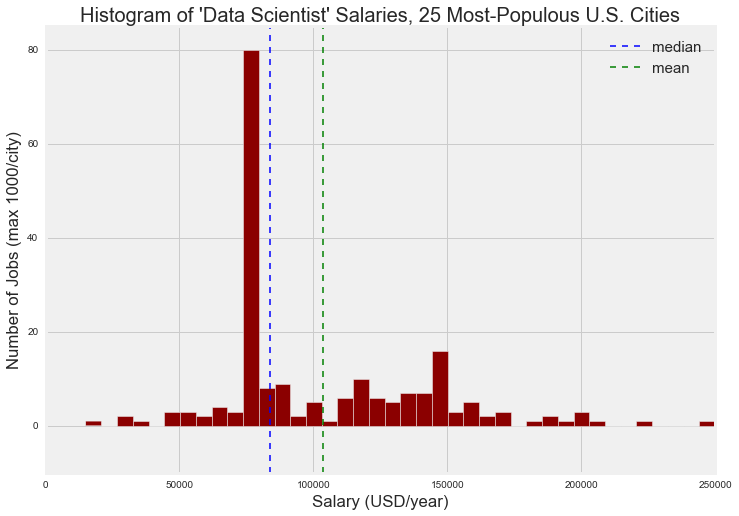

In [29]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(sal_df['parsed_salary'], color = 'darkred', bins = 40)
plt.axvline(sal_df['parsed_salary'].median(), color='b', linestyle='dashed', linewidth=1.5, label = 'median')
plt.axvline(sal_df['parsed_salary'].mean(), color='g', linestyle='dashed', linewidth=1.5, label = 'mean')

plt.title('Histogram of \'Data Scientist\' Salaries, 25 Most-Populous U.S. Cities', fontsize = 20)

# y label
plt.ylabel('Number of Jobs (max 1000/city)')

# x label
plt.xlabel('Salary (USD/year)')

plt.xlim([0, max(sal_df['parsed_salary'])])
plt.ylim([-10, 85])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [96]:
sal_df.head()

,title,location,company,city,state,parsed_salary
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000
1,"Data Scientist, Machine Learning Engineer","Cambridge, MA 02141 (East Cambridge area)",Bivium Group,Boston,MA,125000
2,"Data Scientist, Machine Learning Engineer","Boston, MA 02116 (South End area)",Fanning Personnel,Boston,MA,102500
3,Data Scientist – Predictive Analytics,"Burlington, MA",Workbridge Associates,Boston,MA,122500
4,Data Scientist – Predictive Analytics,"Boston, MA",Workbridge Associates,Boston,MA,75000


In [111]:
sal_df.dtypes

title            object
location         object
company          object
city             object
state            object
parsed_salary    object
dtype: object

In [112]:
sal_df['parsed_salary'] = sal_df['parsed_salary'].apply(lambda x: float(x))

In [113]:
sal_df['parsed_salary'].describe()

count       204.000000
mean     103516.281863
std       39466.270224
min       15000.000000
25%       77500.000000
50%       83750.000000
75%      135000.000000
max      250000.000000
Name: parsed_salary, dtype: float64

In [115]:
median = float(sal_df['parsed_salary'].describe().loc['50%'])
print 'The median salary is %s.' %median

The median salary is 83750.0.


In [116]:
def sal_dummify(x):
    sal_dummy = []
    for i in sal_df['parsed_salary']:
        if i > median:
            sal_dummy.append(1)
        elif i <= median:
            sal_dummy.append(0)
        # This shouldn't happen
        else:
            sal_dummy.append('NaN')
    x['sal_dummy'] = sal_dummy
    return x

In [141]:
sal_dummify(sal_df)
sal_df['sal_dummy'].value_counts()

1    102
0    102
Name: sal_dummy, dtype: int64

In [142]:
sal_df.head(2)

,title,location,company,city,state,parsed_salary,sal_dummy
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1
1,"Data Scientist, Machine Learning Engineer","Cambridge, MA 02141 (East Cambridge area)",Bivium Group,Boston,MA,125000.0,1


In [38]:
#test_df.index = 
#ax = test_df[['A', 'B']].plot(kind='bar', color=['red', 'blue'])

In [153]:
state_df = sal_df[['state', 'sal_dummy', 'parsed_salary']]

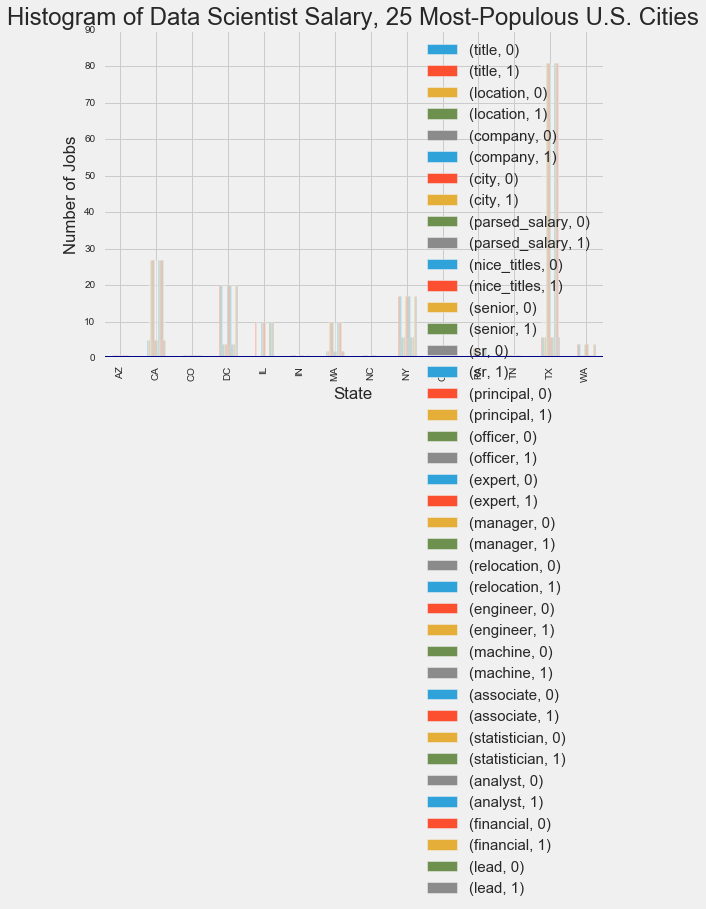

In [283]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

new = sal_df.groupby(['state','sal_dummy']).count().unstack()

new.plot.bar()

plt.axhline(0, color='darkblue')

plt.title('Histogram of Data Scientist Salary, 25 Most-Populous U.S. Cities', fontsize = 24)

# y label
plt.ylabel('Number of Jobs')

#ax.get_xaxis().get_major_formatter().set_useOffset(False)
# x label
plt.xlabel('State')

plt.legend(loc='upper right', fontsize = 15)

plt.show()

In [163]:
print 'There are %s cities' %len(sal_df['city'].unique()) + ' and %s states represented in the dataframe.'\
%len(sal_df['state'].unique())
print '\n'
print 'There are %s cities' %len(df['city'].unique()) + ' and %s states represented in the original, scraped data.'\
%len(df['state'].unique())

There are 20 cities and 14 states represented in the dataframe.


There are 25 cities and 16 states represented in the original, scraped data.


#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

First, do a logistic regression with dummy variables according to cities:

In [165]:
sal_df['city'].value_counts()

Houston          77
Washington       24
New York         23
Boston           12
Chicago          10
Los Angeles      10
San Diego         9
San Jose          9
Dallas            5
Seattle           5
Austin            4
San Francisco     4
Philadelphia      3
Denver            2
Phoenix           2
Nashville         1
Indianapolis      1
Columbus          1
Charlotte         1
San Antonio       1
Name: city, dtype: int64

In [166]:
X_city = pd.DataFrame(sal_df['city'])
X_city['intercept'] = 1
X_city = pd.concat([X_city.drop('city',axis=1), pd.get_dummies(X_city['city'])], axis = 1)
y = sal_df['sal_dummy']

In [167]:
X_city.head(1)

,intercept,Austin,Boston,Charlotte,Chicago,Columbus,Dallas,Denver,Houston,Indianapolis,...,Nashville,New York,Philadelphia,Phoenix,San Antonio,San Diego,San Francisco,San Jose,Seattle,Washington
0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Drop one of the dummy variables (just pick first one on the left):

In [168]:
X_city.drop('Austin', axis=1, inplace=True)
X_city.head(1)

,intercept,Boston,Charlotte,Chicago,Columbus,Dallas,Denver,Houston,Indianapolis,Los Angeles,Nashville,New York,Philadelphia,Phoenix,San Antonio,San Diego,San Francisco,San Jose,Seattle,Washington
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
model_city = st.MNLogit(y, X_city)

In [170]:
model_city_fit = model_city.fit(method = 'bfgs')

         Current function value: 0.286465
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [171]:
model_city_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      184
Method:                           MLE   Df Model:                           19
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.5867
Time:                        02:48:45   Log-Likelihood:                -58.439
converged:                      False   LL-Null:                       -141.40
                                        LLR p-value:                 1.777e-25
=================================================================================
  sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
intercept         1.1854      1.181      1.004      0.315        -1.129     3.500
Boston            0.2707      1.392      0.194      0.846        -2.458     2.999
Charlotte         0.9102      3.413      0.267      0.790        -5.779     7.599
Chicago           3.8217      4.067      0.940      0.347        -4.150    11.793
Columbus          0.9102      3.413      0.267      0.790        -5.779     7.599
Dallas           -1.9792      1.526     -1.297      0.194        -4.969     1.011
Denver           -1.1171      1.843     -0.606      0.544        -4.729     2.495
Houston          -5.1491      1.451     -3.549      0.000        -7.992    -2.306
Indianapolis     -2.1710      2.539     -0.855      0.393        -7.148     2.806
Los Angeles       1.3705      1.700      0.806      0.420        -1.962     4.703
Nashville         0.9102      3.413      0.267      0.790        -5.779     7.599
New York         -0.1024      1.275     -0.080      0.936        -2.600     2.396
Philadelphia      2.0454      3.242      0.631      0.528        -4.308     8.399
Phoenix          -1.1171      1.843     -0.606      0.544        -4.729     2.495
San Antonio      -2.1710      2.539     -0.855      0.393        -7.148     2.806
San Diego         3.6651      3.977      0.922      0.357        -4.130    11.460
San Francisco     0.0299      1.677      0.018      0.986        -3.256     3.316
San Jose         -0.5647      1.372     -0.412      0.681        -3.254     2.125
Seattle           0.3799      1.671      0.227      0.820        -2.896     3.656
Washington        0.6174      1.318      0.468      0.640        -1.966     3.201
=================================================================================
"""

In [172]:
### aic and bic ###
print 'AIC: %s' %model_city_fit.aic
print 'BIC: %s' %model_city_fit.bic

AIC: 156.877777624
BIC: 223.240177501


In [19]:
### marginal effects ###
#model_city_margeff = model_city_fit.get_margeff()
#print model_city_margeff.summary() 

Houston is significant in this model at a 0.05 significance level; while salaries listed in Texas in the data set are lower, it should be noted that Texas is among the U.S. states which does not levy a personal income tax.

In [224]:
X_houston = X_city[['intercept', 'Houston']]
y = sal_df['sal_dummy']

model_houston = st.MNLogit(y, X_houston)

model_houston_fit = model_houston.fit()

model_houston_fit.summary()

Optimization terminated successfully.
         Current function value: 0.341722
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      202
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.5070
Time:                        03:49:10   Log-Likelihood:                -69.711
converged:                       True   LL-Null:                       -141.40
                                        LLR p-value:                 4.851e-33
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
intercept       1.3570      0.220      6.171      0.000         0.926     1.788
Houston        -5.6878      1.030     -5.520      0.000        -7.707    -3.668
===============================================================================
"""

In [225]:
### aic and bic ###
print 'AIC: %s' %model_houston_fit.aic
print 'BIC: %s' %model_houston_fit.bic

AIC: 143.422722823
BIC: 150.058962811


Now, do a logistic regression with state dummy variables:

In [173]:
sal_df['state'].value_counts()

TX    87
CA    32
DC    24
NY    23
MA    12
IL    10
WA     5
PA     3
AZ     2
CO     2
IN     1
TN     1
NC     1
OH     1
Name: state, dtype: int64

In [174]:
X_state = pd.DataFrame(sal_df['state'])
X_state['intercept'] = 1
X_state = pd.concat([X_state.drop('state',axis=1), pd.get_dummies(X_state['state'])], axis = 1)
y = sal_df['sal_dummy'] #same target

In [175]:
X_state.head(1)

,intercept,AZ,CA,CO,DC,IL,IN,MA,NC,NY,OH,PA,TN,TX,WA
0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Drop one of the dummy variables (just pick first one on the left):

In [176]:
X_state.drop('AZ', axis=1, inplace=True)
X_state.head(1)

,intercept,CA,CO,DC,IL,IN,MA,NC,NY,OH,PA,TN,TX,WA
0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
model_state = st.MNLogit(y, X_state)

In [178]:
model_state_fit = model_state.fit(method = 'bfgs')

         Current function value: 0.350241
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [179]:
model_state_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      190
Method:                           MLE   Df Model:                           13
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.4947
Time:                        02:58:08   Log-Likelihood:                -71.449
converged:                      False   LL-Null:                       -141.40
                                        LLR p-value:                 2.198e-23
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
intercept       1.3983      1.774      0.788      0.431        -2.079     4.876
CA              0.4117      1.846      0.223      0.823        -3.206     4.029
CO             -1.7489      2.283     -0.766      0.444        -6.223     2.725
DC              0.0765      1.850      0.041      0.967        -3.550     3.703
IL              5.5945     10.594      0.528      0.597       -15.169    26.358
IN             -3.1655      3.343     -0.947      0.344        -9.717     3.386
MA              0.1210      1.927      0.063      0.950        -3.656     3.898
NC              1.2197      4.351      0.280      0.779        -7.308     9.747
NY             -0.4193      1.835     -0.229      0.819        -4.016     3.177
OH              1.2197      4.351      0.280      0.779        -7.308     9.747
PA              2.8384      5.185      0.547      0.584        -7.323    13.000
TN              1.2197      4.351      0.280      0.779        -7.308     9.747
TX             -4.0101      1.824     -2.198      0.028        -7.586    -0.434
WA              0.4185      2.193      0.191      0.849        -3.880     4.717
===============================================================================
"""

In [180]:
### aic and bic ###
print 'AIC: %s' %model_state_fit.aic
print 'BIC: %s' %model_state_fit.bic

AIC: 170.898483912
BIC: 217.352163826


In [28]:
### marginal effects ###
#model_state_margeff = model_state_fit.get_margeff()
#print model_state_margeff.summary() 

Texas is significant in this model at a 0.05 significance level; again, Texas is among few U.S. states which does not levy a personal income tax.  Salaries may be expected to average lower than nationwide figures.

In [222]:
X_TX = X_state[['intercept', 'TX']]
y = sal_df['sal_dummy']

model_TX = st.MNLogit(y, X_TX)

model_TX_fit = model_TX.fit()

model_TX_fit.summary()

Optimization terminated successfully.
         Current function value: 0.376936
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      202
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.4562
Time:                        03:46:09   Log-Likelihood:                -76.895
converged:                       True   LL-Null:                       -141.40
                                        LLR p-value:                 6.734e-30
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
intercept       1.5198      0.241      6.309      0.000         1.048     1.992
TX             -4.1225      0.487     -8.467      0.000        -5.077    -3.168
===============================================================================
"""

In [223]:
### aic and bic ###
print 'AIC: %s' %model_TX_fit.aic
print 'BIC: %s' %model_TX_fit.bic

AIC: 157.790041555
BIC: 164.426281542


AIC and BIC have both improved from the full city & state models when switching to Houston & TX-only dummy variables!  Since the scores are lower for Houston, let's keep that one for now (and note that Dallas's salaries are higher on average in this data set).

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [181]:
sal_df.head(1)

,title,location,company,city,state,parsed_salary,sal_dummy
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1


Make a list of (non-unique) terms found in 'title' entries; ignore case and symbols.

In [182]:
all_terms = []
for i in sal_df['title']:
    x = i.lower()
    x = re.sub(r'[^\w]', ' ', x)
    x = x.split(' ')
    all_terms = all_terms + x
    
unique_terms = list(set(all_terms))

Figure out which of these terms appear the most frequently in the dataframe:

In [183]:
term_counts = []
for i in unique_terms:
    count = all_terms.count(i)
    term_counts.append(count)

count_df = pd.DataFrame([unique_terms, term_counts]).T
count_df.columns = ['term', 'count']

In [202]:
count_df.sort('count', ascending = False).head(50)

In [185]:
def titleify(df):
    '''This function adds a column containing a list of cleaned title terms to dataframe argument.'''
    titles = []
    for i in df['title']:
        x = i.lower()
        x = re.sub(r'[^\w]', ' ', x)
        titles.append(x)
    df['nice_titles'] = titles
    return df

In [186]:
titleify(sal_df)
sal_df.head(1)

,title,location,company,city,state,parsed_salary,sal_dummy,nice_titles
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1,data scientist predictive analytics


In [187]:
terms = ['senior', 'sr', 'principal', 'officer', 'expert', 'manager', 'relocation', 'engineer', 'machine', \
        'associate', 'statistician', 'analyst', 'financial', 'lead']

In [192]:
sal_df['senior'] = sal_df['nice_titles'].str.extract('(senior)')
sal_df['sr'] = sal_df['nice_titles'].str.extract('(sr)')
sal_df['principal'] = sal_df['nice_titles'].str.extract('(principal)')
sal_df['officer'] = sal_df['nice_titles'].str.extract('(officer)')
sal_df['expert'] = sal_df['nice_titles'].str.extract('(expert)')
sal_df['manager'] = sal_df['nice_titles'].str.extract('(manager)')
sal_df['relocation'] = sal_df['nice_titles'].str.extract('(relocation)')
sal_df['engineer'] = sal_df['nice_titles'].str.extract('(engineer)')
sal_df['machine'] = sal_df['nice_titles'].str.extract('(machine)')
sal_df['associate'] = sal_df['nice_titles'].str.extract('(associate)')
sal_df['statistician'] = sal_df['nice_titles'].str.extract('(statistician)')
sal_df['analyst'] = sal_df['nice_titles'].str.extract('(analyst)')
sal_df['financial'] = sal_df['nice_titles'].str.extract('(financial)')
sal_df['lead'] = sal_df['nice_titles'].str.extract('(lead)')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pan

In [193]:
sal_df.head(1)

,title,location,company,city,state,parsed_salary,sal_dummy,nice_titles,senior,sr,...,expert,manager,relocation,engineer,machine,associate,statistician,analyst,financial,lead
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1,data scientist predictive analytics,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This needs to be turned into a function:

In [194]:
senior = []
for i in sal_df['senior']:
    if i == 'senior':
        senior.append(1)
    else:
        senior.append(0)
sal_df['senior'] = senior

sr = []
for i in sal_df['sr']:
    if i == 'sr':
        sr.append(1)
    else:
        sr.append(0)
sal_df['sr'] = sr

principal = []
for i in sal_df['principal']:
    if i == 'principal':
        principal.append(1)
    else:
        principal.append(0)
sal_df['principal'] = principal

officer = []
for i in sal_df['officer']:
    if i == 'officer':
        officer.append(1)
    else:
        officer.append(0)
sal_df['officer'] = officer

expert = []
for i in sal_df['expert']:
    if i == 'expert':
        expert.append(1)
    else:
        expert.append(0)
sal_df['expert'] = expert

manager = []
for i in sal_df['manager']:
    if i == 'manager':
        manager.append(1)
    else:
        manager.append(0)
sal_df['manager'] = manager

relocation = []
for i in sal_df['relocation']:
    if i == 'relocation':
        relocation.append(1)
    else:
        relocation.append(0)
sal_df['relocation'] = relocation

engineer = []
for i in sal_df['engineer']:
    if i == 'engineer':
        engineer.append(1)
    else:
        engineer.append(0)
sal_df['engineer'] = engineer

machine = []
for i in sal_df['machine']:
    if i == 'machine':
        machine.append(1)
    else:
        machine.append(0)
sal_df['machine'] = machine

associate = []
for i in sal_df['associate']:
    if i == 'associate':
        associate.append(1)
    else:
        associate.append(0)
sal_df['associate'] = associate

statistician = []
for i in sal_df['statistician']:
    if i == 'statistician':
        statistician.append(1)
    else:
        statistician.append(0)
sal_df['statistician'] = statistician

analyst = []
for i in sal_df['analyst']:
    if i == 'analyst':
        analyst.append(1)
    else:
        analyst.append(0)
sal_df['analyst'] = analyst

financial = []
for i in sal_df['financial']:
    if i == 'financial':
        financial.append(1)
    else:
        financial.append(0)
sal_df['financial'] = financial

lead = []
for i in sal_df['lead']:
    if i == 'lead':
        lead.append(1)
    else:
        lead.append(0)
sal_df['lead'] = lead

In [226]:
sal_df.head(1)

,title,location,company,city,state,parsed_salary,sal_dummy,nice_titles,senior,sr,...,expert,manager,relocation,engineer,machine,associate,statistician,analyst,financial,lead
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1,data scientist predictive analytics,0,0,...,0,0,0,0,0,0,0,0,0,0


In [227]:
X_title = pd.DataFrame(sal_df[['senior', 'sr', 'principal', 'manager', 'relocation', 'engineer', \
        'machine', 'associate', 'statistician', 'analyst', 'financial', 'lead']])
X_title['intercept'] = 1
y = sal_df['sal_dummy'] # same target

In [228]:
X_title.head(1)

,senior,sr,principal,manager,relocation,engineer,machine,associate,statistician,analyst,financial,lead,intercept
0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [229]:
model_title = st.MNLogit(y, X_title)

In [230]:
model_title_fit = model_title.fit(method = 'bfgs')

         Current function value: 0.378738
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [231]:
model_title_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      191
Method:                           MLE   Df Model:                           12
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.4536
Time:                        03:52:33   Log-Likelihood:                -77.262
converged:                      False   LL-Null:                       -141.40
                                        LLR p-value:                 1.367e-21
================================================================================
 sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
senior           4.0251      1.229      3.276      0.001         1.617     6.433
sr              -0.5136      1.162     -0.442      0.659        -2.791     1.764
principal       -2.3455      1.446     -1.622      0.105        -5.180     0.489
manager         -1.1976      1.448     -0.827      0.408        -4.035     1.640
relocation       1.1054      4.344      0.254      0.799        -7.408     9.619
engineer         1.4107      0.888      1.589      0.112        -0.329     3.150
machine         -4.3325      0.938     -4.617      0.000        -6.172    -2.493
associate       -7.6631      5.794     -1.322      0.186       -19.020     3.694
statistician     1.3718      1.408      0.975      0.330        -1.387     4.131
analyst         -1.4754      1.141     -1.293      0.196        -3.712     0.761
financial       -4.9619      1.983     -2.502      0.012        -8.848    -1.075
lead             3.4036      3.502      0.972      0.331        -3.461    10.268
intercept        1.0188      0.283      3.594      0.000         0.463     1.574
================================================================================
"""

In [219]:
### aic and bic ###
print 'AIC: %s' %model_title_fit.aic
print 'BIC: %s' %model_title_fit.bic

AIC: 198.233719481
BIC: 238.051159407


In [220]:
### marginal effects ###
#model_title_margeff = model_title_fit.get_margeff()
#print model_title_margeff.summary()

Thus, in this model, 'senior', 'machine', and 'financial' job title terms are significant at a 0.05 level.

In [236]:
X_nicetitles = X_title[['senior', 'machine', 'financial']]
X_nicetitles['intercept'] = 1
y = sal_df['sal_dummy']

model_nicetitles = st.MNLogit(y, X_nicetitles)

model_nicetitles_fit = model_nicetitles.fit()

model_nicetitles_fit.summary()

         Current function value: 0.539077
         Iterations: 35


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Rebecca/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      200
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.2223
Time:                        04:01:17   Log-Likelihood:                -109.97
converged:                      False   LL-Null:                       -141.40
                                        LLR p-value:                 1.438e-13
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
senior          3.7622      1.125      3.343      0.001         1.557     5.968
machine        -2.3722      0.444     -5.347      0.000        -3.242    -1.503
financial     -27.4138   2.45e+05     -0.000      1.000      -4.8e+05   4.8e+05
intercept       0.5180      0.180      2.872      0.004         0.164     0.872
===============================================================================
"""

In [237]:
### aic and bic ###
print 'AIC: %s' %model_nicetitles_fit.aic
print 'BIC: %s' %model_nicetitles_fit.bic

AIC: 227.943280313
BIC: 241.215760288


That's quite an increase in AIC and BIC!  'financial' appears to be insignificant now; let's try taking it out.

In [238]:
X_nicertitles = X_title[['senior', 'machine']]
X_nicertitles['intercept'] = 1
y = sal_df['sal_dummy']

model_nicertitles = st.MNLogit(y, X_nicertitles)

model_nicertitles_fit = model_nicertitles.fit()

model_nicertitles_fit.summary()

Optimization terminated successfully.
         Current function value: 0.575850
         Iterations 7


/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      201
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.1692
Time:                        04:02:03   Log-Likelihood:                -117.47
converged:                       True   LL-Null:                       -141.40
                                        LLR p-value:                 4.054e-11
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
senior          3.7814      1.122      3.371      0.001         1.583     5.980
machine        -2.2233      0.440     -5.049      0.000        -3.086    -1.360
intercept       0.3669      0.172      2.130      0.033         0.029     0.705
===============================================================================
"""

In [239]:
### aic and bic ###
print 'AIC: %s' %model_nicertitles_fit.aic
print 'BIC: %s' %model_nicertitles_fit.bic

AIC: 240.946781226
BIC: 250.901141207


In [241]:
sal_df.head(1)

,title,location,company,city,state,parsed_salary,sal_dummy,nice_titles,senior,sr,...,expert,manager,relocation,engineer,machine,associate,statistician,analyst,financial,lead
0,Data Scientist – Predictive Analytics,"Waltham, MA",Jobspring Partners,Boston,MA,135000.0,1,data scientist predictive analytics,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
X_big = pd.DataFrame(zip(sal_df['senior'], sal_df['machine'], X_city['Houston']))
X_big.columns = ['senior', 'machine', 'Houston']
X_big['intercept'] = 1
y = sal_df['sal_dummy']

model_big = st.MNLogit(y, X_big)

model_big_fit = model_big.fit(method = 'bfgs')

model_big_fit.summary()

Optimization terminated successfully.
         Current function value: 0.336440
         Iterations: 31
         Function evaluations: 32
         Gradient evaluations: 32


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      200
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.5146
Time:                        04:08:23   Log-Likelihood:                -68.634
converged:                       True   LL-Null:                       -141.40
                                        LLR p-value:                 2.418e-31
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
senior          1.3766      1.114      1.236      0.217        -0.807     3.560
machine        -0.1594      0.734     -0.217      0.828        -1.599     1.280
Houston        -5.5155      1.082     -5.097      0.000        -7.637    -3.394
intercept       1.2702      0.234      5.439      0.000         0.812     1.728
===============================================================================
"""

In [247]:
### aic and bic ###
print 'AIC: %s' %model_big_fit.aic
print 'BIC: %s' %model_big_fit.bic

AIC: 145.267553691
BIC: 158.540033667


Try model without 'machine':

In [246]:
X_lessbig = pd.DataFrame(zip(sal_df['senior'], X_city['Houston']))
X_lessbig.columns = ['senior', 'Houston']
X_lessbig['intercept'] = 1
y = sal_df['sal_dummy']

model_lessbig = st.MNLogit(y, X_lessbig)

model_lessbig_fit = model_lessbig.fit(method = 'bfgs')

model_lessbig_fit.summary()

Optimization terminated successfully.
         Current function value: 0.336554
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      201
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.5145
Time:                        04:11:33   Log-Likelihood:                -68.657
converged:                       True   LL-Null:                       -141.40
                                        LLR p-value:                 2.554e-32
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
senior          1.3073      1.063      1.230      0.219        -0.775     3.390
Houston        -5.5891      1.032     -5.417      0.000        -7.611    -3.567
intercept       1.2585      0.227      5.553      0.000         0.814     1.703
===============================================================================
"""

In [248]:
### aic and bic ###
print 'AIC: %s' %model_lessbig_fit.aic
print 'BIC: %s' %model_lessbig_fit.bic

AIC: 143.314066275
BIC: 153.268426257


Remind ourselves what the Houston-only model looked like:

In [251]:
model_houston_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              sal_dummy   No. Observations:                  204
Model:                        MNLogit   Df Residuals:                      202
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.5070
Time:                        04:14:28   Log-Likelihood:                -69.711
converged:                       True   LL-Null:                       -141.40
                                        LLR p-value:                 4.851e-33
===============================================================================
sal_dummy=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
intercept       1.3570      0.220      6.171      0.000         0.926     1.788
Houston        -5.6878      1.030     -5.520      0.000        -7.707    -3.668
===============================================================================
"""

In [252]:
print 'AIC: %s' %model_houston_fit.aic
print 'BIC: %s' %model_houston_fit.bic

AIC: 143.422722823
BIC: 150.058962811


Looks like we're just going to use 'Houston' dummy variable as our only feature!

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [253]:
skl_model = lm.LogisticRegression()

X = X_houston
X['intercept'] = 1
y = sal_df['sal_dummy']

skl_model.fit(X, y)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [257]:
X.head(1)

,intercept,Houston
0,1,0.0


In [258]:
X['probability'] = skl_model.predict_proba(X).T[1]

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [259]:
X['probability'].head()

0    0.760386
1    0.760386
2    0.760386
3    0.760386
4    0.760386
Name: probability, dtype: float64

In [261]:
X.head(1)

,intercept,Houston,probability
0,1,0.0,0.760386


In [262]:
predictions = skl_model.predict(X[['intercept', 'Houston']])

cm = confusion_matrix(y, predictions)
cm

array([[ 76,  26],
       [  1, 101]])

In [263]:
sum(predictions)

127

Therefore, the right-hand entries in the confusion matrix represent the true and false positives (since 26 + 101 = 127).

In [264]:
import matplotlib.patheffects as path_effects

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline
    return

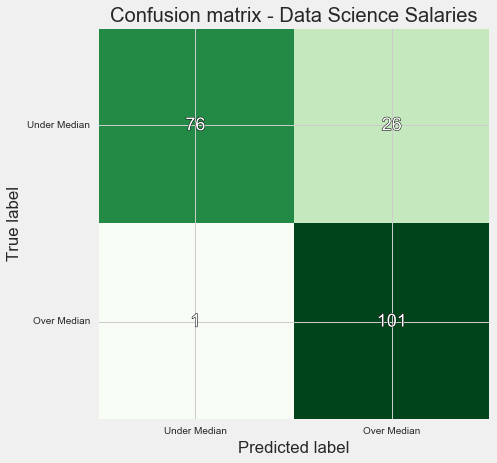

In [265]:
plot_confusion_matrix(cm, title='Confusion matrix - Data Science Salaries', labels=['Under Median','Over Median'], \
                      cmap=plt.cm.Greens)

In [266]:
from sklearn.metrics import roc_curve

roc = roc_curve(y, predictions)
roc

(array([ 0.        ,  0.25490196,  1.        ]),
 array([ 0.        ,  0.99019608,  1.        ]),
 array([2, 1, 0]))

In [268]:
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

pred1 = skl_model.predict_proba(X[['intercept', 'Houston']]).T[1]
roc = roc_curve(y, pred1)

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    return

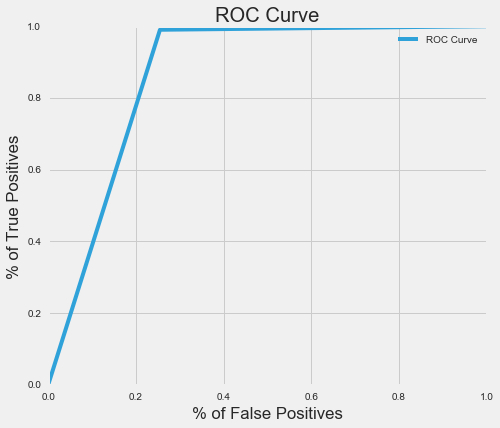

In [269]:
getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives')

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [270]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#from sklearn.metrics import auc 

,intercept,Houston,probability
0,1,0.0,0.760386


In [272]:
cross_val_score(skl_model, X[['intercept', 'Houston']], y, n_jobs=1, cv=5)

array([ 0.69047619,  1.        ,  0.975     ,  1.        ,  0.675     ])

In [273]:
cross_val_score(skl_model, X[['intercept', 'Houston']], y, n_jobs=1, cv=5).mean()

0.86809523809523803

In [274]:
print 'accuracy: %s' %accuracy_score(y, predictions)
print 'precision: %s' %precision_score(y, predictions)
print 'recall: %s' %recall_score(y, predictions)
print 'area under curve: %s' %roc_auc_score(y, predictions)

accuracy: 0.867647058824
precision: 0.795275590551
recall: 0.990196078431
area under curve: 0.867647058824


Our recall (TP/P) is very good; this means that we are identifying a large proportion of the positives correctly.  On the other hand, our precision (TP/(TP + FP)) is not quite as good, meaning that our model is identifying some false positives along with the nice proportion of true positives.  In our example, some of our salaries are identified as being over the median when they are, in fact, under it.  

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [275]:
model_l1 = lm.LogisticRegression(penalty = 'l1')

X_l1 = X[['intercept', 'Houston']]
y = sal_df['sal_dummy']

model_l1.fit(X_l1, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [276]:
X['prob_l1'] = model_l1.predict_proba(X[['intercept', 'Houston']]).T[1]

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [277]:
predictions = model_l1.predict(X[['intercept', 'Houston']])

cm = confusion_matrix(y, predictions)
cm

array([[ 76,  26],
       [  1, 101]])

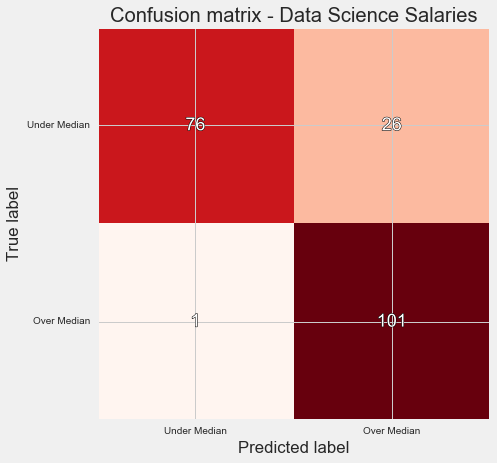

In [278]:
plot_confusion_matrix(cm, title='Confusion matrix - Data Science Salaries', labels=['Under Median','Over Median'], \
                      cmap=plt.cm.Reds)

L1 vs L2 penalty does not seem to make a difference in the predictions of these models; this is perhaps because of the very large proportion of lower-salaried Data Science job results found in Tennessee and Texas.

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [24]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [25]:
## YOUR CODE HERE